In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix
from collections import Counter

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


###Data Loading

In [ ]:
df = pd.read_csv('fully_processed_data.csv')
df = df.drop('Unnamed: 0', axis=1)
df.head()

,myear,calcage,leader,deputy,support,disabled,hired,sherpa,tibetan,msuccess,mclaimed,mdisputed,msolo,mtraverse,mski,mparapente,mspeed,mo2none,mo2climb,mo2descent,mo2sleep,mo2medical,death,hcn,host,totmembers,tothired,nohired,citizen_is_nation,hired_ratio,same_nat_as_leader,0,1,2,3,4,5,6,7,8,...,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483
0,1988,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,17,10,0,1,0.588235,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1988,40,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,17,10,0,0,0.588235,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1988,29,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,17,10,0,0,0.588235,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1988,27,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,17,10,0,0,0.588235,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1988,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,17,10,0,0,0.588235,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
y_summit = df.msuccess
y_death = df.death
X = df.drop(['msuccess', 'death'], axis=1)

In [ ]:
modern_data = pd.read_csv('modern_no_year.csv')
modern_data = modern_data.drop('Unnamed: 0', axis=1)
modern_data.head()

,calcage,leader,deputy,support,disabled,hired,sherpa,tibetan,msuccess,mclaimed,mdisputed,msolo,mtraverse,mski,mparapente,mspeed,mo2none,mo2climb,mo2descent,mo2sleep,mo2medical,death,host,totmembers,tothired,nohired,citizen_is_nation,hired_ratio,same_nat_as_leader,0,1,2,3,4,5,6,7,8,9,10,...,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483
0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,7,0,1,0,0.0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,7,0,1,0,0.0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,7,0,1,0,0.0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,7,0,1,0,0.0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,7,0,1,1,0.0,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_mod_summit = modern_data.msuccess
y_mod_death = modern_data.death
X_mod = modern_data.drop(['msuccess', 'death'], axis=1)

###Utility Functions

In [ ]:
def graph_and_stats(model, X_valid, y_valid):

  predictions = model.predict(X_valid)

  print("Log Loss:", log_loss(y_valid, predictions), "\n")

  confusion = confusion_matrix(y_valid, predictions)

  # calculating all the required stats for full understanding
  acc = (confusion[0][0] + confusion[1][1])/ (confusion[0][0]
      + confusion[0][1] + confusion[1][0] + confusion[1][1])
  ner = (confusion[0][0] + confusion[0][1]) / (confusion[1][0]
        + confusion[1][1])
  missclass = (confusion[0][1] + confusion[1][0]) / (
      confusion[0][0] + confusion[0][1] + confusion[1][0] +
      confusion[1][1])
  tpr = confusion[1][1] / (confusion[1][0] + confusion[1][1])
  fpr = confusion[0][1] / (confusion[0][0] + confusion[0][1])
  tnr = confusion[0][0] / (confusion[0][0] + confusion[0][1])
  fnr = confusion[1][0] / (confusion[1][0] + confusion[1][1])
  prc = confusion[1][1] / (confusion[0][1] + confusion[1][1])
  f_measure = 2 * ((tpr * prc) / (tpr + prc))

  print("Accuracy:", acc)
  print("Null error rate:", ner)
  print("Error rate:", missclass)
  print("True Positive Rate:", tpr) # Sensitivity also recall
  print("False Positive Rate:", fpr) 
  print("True Negitive Rate:", tnr) # Specificty
  print("False Negitive Rate:", fnr)
  print("Precision:", prc)
  print("F-measure:", f_measure, '\n')

  # scaling the confusion matricies
  temp_con = []
  for i in confusion:
    temp = i / sum(i) * 100
    temp_con.append(temp)

  confusion = temp_con

  plt.figure(figsize=(15, 6))
  plt.matshow(confusion, cmap = 'Blues')
          
  for (i, j), z in np.ndenumerate(confusion):
      if(0 < z < 50):
          plt.text(j, i, '{0:0.2f}'.format(z), ha='center', va='center', color =
                  'black')
          
      else:
          plt.text(j, i, '{0:0.2f}'.format(z), ha='center', va='center', color =
                  'white')

  plt.ylabel("Truth")
  plt.xlabel("Prediction")
  plt.tick_params(bottom = False, top = True, labelbottom = True,
                  labeltop = False)
  plt.grid(True, which = 'minor')
  #plt.savefig("Graphs/.png", bbox_inches='tight', dpi=600)

##Summit

In [ ]:
X_summit_train,X_summit_valid,y_summit_train,y_summit_valid = train_test_split(
    X, y_summit, train_size=0.8, test_size=0.2, random_state=0)

In [ ]:
summit_model = XGBClassifier(
                             early_stopping_rounds=10,
                             lr = 0.05,
                             n_estimators=1000,
                             verbosity=1,
                             max_deapth=4
                             )

summit_model.fit(X_summit_train, y_summit_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
              gamma=0, learning_rate=0.1, lr=0.05, max_deapth=4,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

Log Loss: 3.2227427988323374 

Accuracy: 0.9066937119675457
Null error rate: 0.9879032258064516
Error rate: 0.09330628803245436
True Positive Rate: 0.9581653225806451
False Positive Rate: 0.14540816326530612
True Negitive Rate: 0.8545918367346939
False Negitive Rate: 0.041834677419354836
Precision: 0.8696248856358646
F-measure: 0.9117505995203837 



<Figure size 1080x432 with 0 Axes>

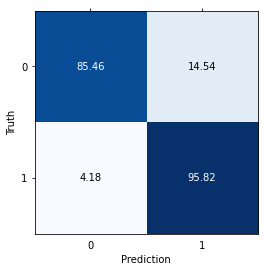

In [ ]:
graph_and_stats(summit_model, X_summit_valid, y_summit_valid)

##Modern Summiting

In [ ]:
X_mod_summit_train,X_mod_summit_valid,y_mod_summit_train,y_mod_summit_valid = (
    train_test_split(X_mod, y_mod_summit, train_size=0.8, test_size=0.2,
                     random_state=0))

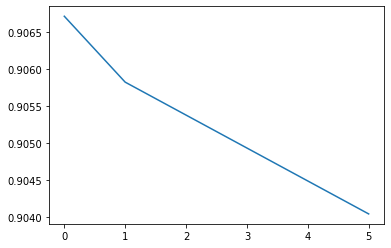

In [ ]:
# model tuning
# n_estimators 650 peak
# early stopping rounds has no effect, keeping default
# lr no effect keeping 0.05
# subsample around 0.86 
# colsample_bytree around 0.65
# gamma 0 is best

acc = []
for i in [0,1,5]:
  temp_model = XGBClassifier(
                             early_stopping_rounds=10,
                             lr = 0.05,
                             n_estimators=650,
                             verbosity=1,
                             max_deapth=3,
                             subsample = 0.85,
                             colsample_bytree = 0.65,
                             gamma = i
                             ).fit(X_mod_summit_train, y_mod_summit_train)
  temp_predictions = temp_model.predict(X_mod_summit_valid)
  acc.append(accuracy_score(y_mod_summit_valid, temp_predictions))

plt.figure()
plt.plot([0,1,5], acc)

In [ ]:
summit_mod_model = XGBClassifier(
                             early_stopping_rounds=10,
                             lr = 0.05,
                             n_estimators=1000,
                             verbosity=1,
                             max_deapth=3,
                             )

summit_mod_model.fit(X_mod_summit_train, y_mod_summit_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
              gamma=0, learning_rate=0.1, lr=0.05, max_deapth=3,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

Log Loss: 3.2938652170272134 

Accuracy: 0.9046345811051694
Null error rate: 0.7660020986358866
Error rate: 0.09536541889483066
True Positive Rate: 0.9648478488982162
False Positive Rate: 0.17397260273972603
True Negitive Rate: 0.826027397260274
False Negitive Rate: 0.03515215110178384
Precision: 0.8786430960344004
F-measure: 0.9197299324831207 



<Figure size 1080x432 with 0 Axes>

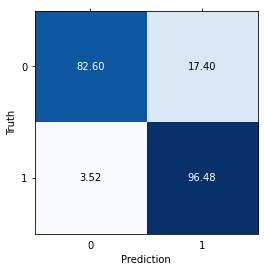

In [ ]:
graph_and_stats(summit_mod_model, X_mod_summit_valid, y_mod_summit_valid)

In [ ]:
# optimised model
summit_mod_model = XGBClassifier(
                             early_stopping_rounds=10,
                             lr = 0.05,
                             n_estimators=650,
                             verbosity=1,
                             max_deapth=3,
                             subsample = 0.85,
                             colsample_bytree = 0.65,
                             gamma = 0
                             )

summit_mod_model.fit(X_mod_summit_train, y_mod_summit_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.65,
              early_stopping_rounds=10, gamma=0, learning_rate=0.1, lr=0.05,
              max_deapth=3, max_delta_step=0, max_depth=3, min_child_weight=1,
              missing=None, n_estimators=650, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.85, verbosity=1)

Log Loss: 3.222038646505926 

Accuracy: 0.9067142008318478
Null error rate: 0.7660020986358866
Error rate: 0.0932857991681521
True Positive Rate: 0.9706190975865687
False Positive Rate: 0.17671232876712328
True Negitive Rate: 0.8232876712328767
False Negitive Rate: 0.02938090241343127
Precision: 0.8776091081593927
F-measure: 0.9217737917289487 



<Figure size 1080x432 with 0 Axes>

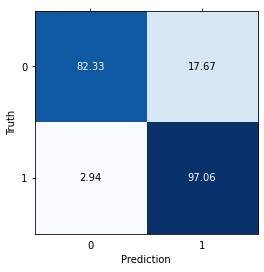

In [ ]:
graph_and_stats(summit_mod_model, X_mod_summit_valid, y_mod_summit_valid)

##Death

In [ ]:
X_death_train, X_death_valid, y_death_train, y_death_valid = train_test_split(
    X, y_death, train_size=0.8, test_size=0.2, random_state=0)

In [ ]:
death_model = XGBClassifier(
                            early_stopping_rounds=10,
                            lr = 0.05,
                            n_estimators=1000,
                            verbosity=1,
                            max_deapth=4
                            )

death_model.fit(X_death_train, y_death_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
              gamma=0, learning_rate=0.1, lr=0.05, max_deapth=4,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

Log Loss: 0.33277887925609817 

Accuracy: 0.9903651115618661
Null error rate: 95.1951219512195
Error rate: 0.009634888438133874
True Positive Rate: 0.2682926829268293
False Positive Rate: 0.0020497053548552396
True Negitive Rate: 0.9979502946451447
False Negitive Rate: 0.7317073170731707
Precision: 0.5789473684210527
F-measure: 0.36666666666666664 



<Figure size 1080x432 with 0 Axes>

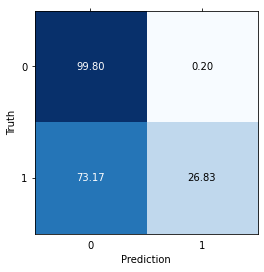

In [ ]:
graph_and_stats(death_model, X_death_valid, y_death_valid)

##Death with undersampling


In [ ]:
sampler = RandomUnderSampler(random_state = 0, replacement=True)

X_death_resampled_u, y_death_resampled_u = sampler.fit_resample(X_death_train,
                                                            y_death_train)

# Getting data in the right format
X_death_resampled_u = pd.DataFrame(X_death_resampled_u,
                                   columns=X_death_valid.columns)
y_death_resampled_u = pd.Series(y_death_resampled_u)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
death_model_u = XGBClassifier(
                            early_stopping_rounds=10,
                            lr = 0.05,
                            n_estimators=1000,
                            verbosity=1,
                            max_deapth=6,
                            )

death_model_u.fit(X_death_resampled_u, y_death_resampled_u)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
              gamma=0, learning_rate=0.1, lr=0.05, max_deapth=6,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

Log Loss: 9.536914366045872 

Accuracy: 0.7238843813387424
Null error rate: 95.1951219512195
Error rate: 0.2761156186612576
True Positive Rate: 0.7560975609756098
False Positive Rate: 0.27645400973610046
True Negitive Rate: 0.7235459902638995
False Negitive Rate: 0.24390243902439024
Precision: 0.027927927927927927
F-measure: 0.05386620330147698 



<Figure size 1080x432 with 0 Axes>

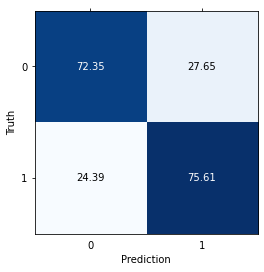

In [ ]:
graph_and_stats(death_model_u, X_death_valid, y_death_valid)

##Death with oversampling


In [ ]:
sampler = SMOTE(random_state = 0)

X_death_resampled_o, y_death_resampled_o = sampler.fit_resample(X_death_train,
                                                                y_death_train)

# Getting data in the right format
X_death_resampled_o = pd.DataFrame(X_death_resampled_o,
                                   columns=X_death_valid.columns)
y_death_resampled_o = pd.Series(y_death_resampled_o)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
death_model_o = XGBClassifier(
                            early_stopping_rounds=10,
                            lr = 0.05,
                            n_estimators=1000,
                            verbosity=1,
                            max_deapth=6,
                            )

death_model_o.fit(X_death_resampled_o, y_death_resampled_o)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
              gamma=0, learning_rate=0.1, lr=0.05, max_deapth=6,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

Log Loss: 0.3765663741753944 

Accuracy: 0.9890973630831643
Null error rate: 95.1951219512195
Error rate: 0.0109026369168357
True Positive Rate: 0.2682926829268293
False Positive Rate: 0.003330771201639764
True Negitive Rate: 0.9966692287983603
False Negitive Rate: 0.7317073170731707
Precision: 0.4583333333333333
F-measure: 0.3384615384615385 



<Figure size 1080x432 with 0 Axes>

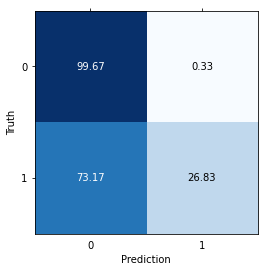

In [ ]:
graph_and_stats(death_model_o, X_death_valid, y_death_valid)